In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import find_peaks, peak_widths
from scipy.optimize import curve_fit

plt.rcParams.update({"font.size": 14, "font.family": "serif"})

In [2]:
power = np.array([0.107, 0.0243, 0.182, 0.360, 0.523, 0.7, 0.94, 1.16, 
                 1.51, 1.72, 1.99, 2.18, 2.42, 2.72, 3.03, 3.31, 3.70,
                 4.01, 4.28, 4.64, 5.00, 5.34, 5.75, 6.13, 6.45, 6.87,
                 7.22, 7.58, 7.85, 8.14, 8.39, 8.61, 8.79, 9.02, 9.16,
                 9.43, 9.64, 9.89, 10.10, 10.30, 10.51, 10.70, 10.80, 10.87
                 ])


coef = (7.81 - 6.07) / (3.81 - 5.50)
print(coef)

power -= 10.87
power *= coef


-1.0295857988165678


In [3]:
data = pd.read_csv("./data_saturation/scope_csv_4.csv", skiprows=1)
t, ch1, ch2 = data.iloc[::,0], data.iloc[::,1], data.iloc[::,2]

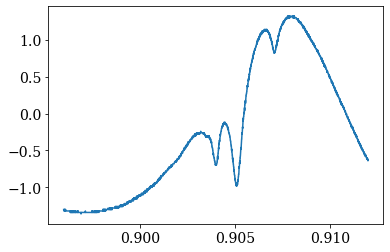

In [4]:
plt.plot(t, ch1)

In [5]:
from scipy.spatial import ConvexHull
from scipy import interpolate


def convex_floor(t, ch1, left=None, right=None):
    if left is None:
        left = 0
    if right is None:
        right = -1
    x, y = np.array(t[left:right]),  np.array(ch1[left:right])

    points = np.array([x, y])
    hull = ConvexHull(points.T)
    idx = hull.vertices
    
    x1, y1 = x[idx], y[idx]
    idx_sorted = np.argsort(x1)
    x1, y1 = x1[idx_sorted], y1[idx_sorted]
    
    f = interpolate.interp1d(x1, y1)
    y_new = f(x)-y
    
    kernel_size = 5
    kernel = np.ones(kernel_size)/kernel_size
    y_conv = np.convolve(y_new, kernel, mode="same")
    
    return [[np.array(x), np.array(y_conv)], [np.array(f(x)), idx]]


def peaks(x, y):
    peaks, _ = find_peaks(y_conv, height=0.05, distance=80)
    
    
def mode(x, sigma, mu, ampl, const):
    return ampl*np.exp(-(x-mu)**2/(2*sigma**2)) + const

def mode0(x, sigma, mu, ampl):
    return ampl*np.exp(-(x-mu)**2/(2*sigma**2))

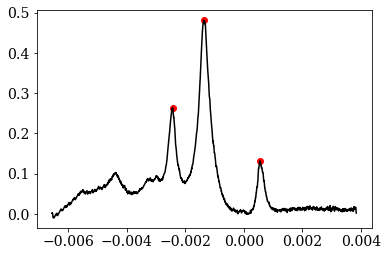

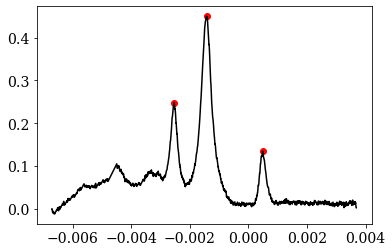

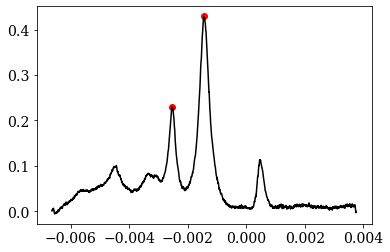

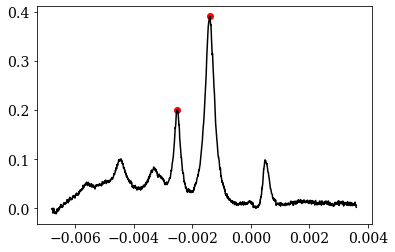

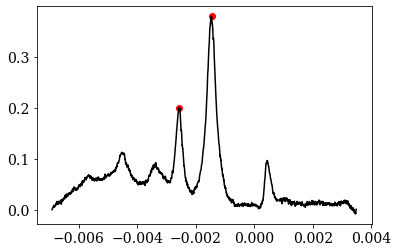

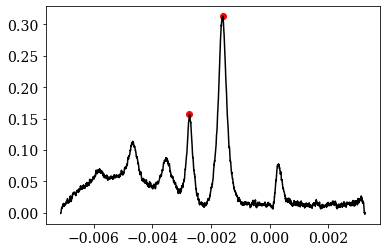

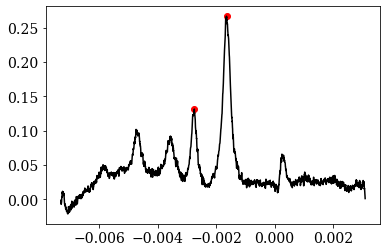

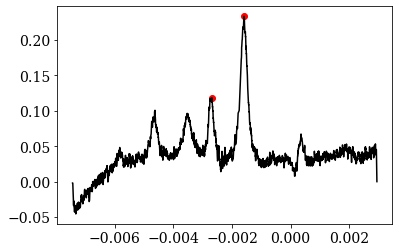

In [6]:
for i in range(39, 47):
    data = pd.read_csv("./data_saturation/scope_csv_{}.csv".format(i), skiprows=1)
    t, ch1, ch2 = data.iloc[::,0], data.iloc[::,1], data.iloc[::,2]
    t -= t[np.argmax(ch1)]
    ch1 -= ch1[100]
    ch1 /= np.max(ch1)
    
    x, y = convex_floor(t, ch1, 1000, 3600)[0]
    
    peaks, _ = find_peaks(y, height=0.115, distance=200)
    
    plt.figure()
    plt.plot(x, y, color="black")
    plt.scatter(x[peaks], y[peaks], color="red")

In [7]:
def lorenz(x, g, a, m):
    return a * (g/2)**2 / ((x - m)**2 + (g/2)**2)

# def lorenz_sum(x, g1, a1, m1, g2, a2, m2, g3, a3, m3, g4, a4, m4):
#     return lorenz(x, g1, a1, m1) + lorenz(x, g2, a2, m2) + lorenz(x, g3, a3, m3) + lorenz(x, g4, a4, m4)

def lorenz_sum(x, g1, a1, m1, g2, a2, m2, g3, a3, m3):
    return lorenz(x, g1, a1, m1) + lorenz(x, g2, a2, m2) + lorenz(x, g3, a3, m3) 


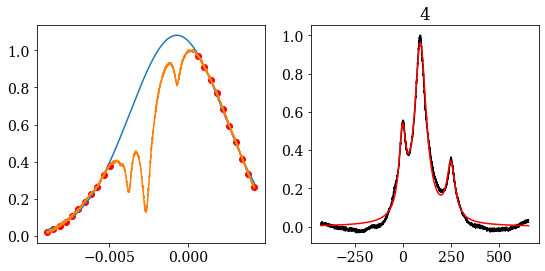

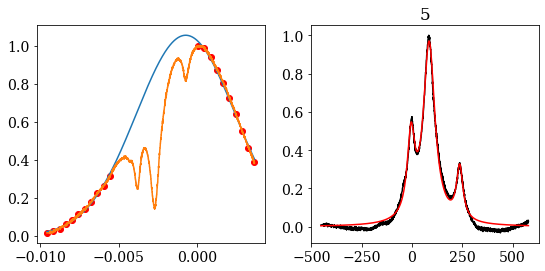

In [8]:
# plt.figure(figsize=(8, 8))

Gamma0 = []
for i in range(4, 6, 1):
    data = pd.read_csv("./data_saturation/scope_csv_{}.csv".format(i), skiprows=1)
    t, ch1, ch2 = data.iloc[::,0], data.iloc[::,1], data.iloc[::,2]
    t-= t[np.argmax(ch1)]
    ch1 -= ch1[100]
    ch1 /= np.max(ch1)
    
#     plt.subplot(221)
#     plt.plot(t, ch1, color='black')
    
    a, b = 700,4000
    x, y = np.array(t[a:b]), np.array(ch1[a:b])
    
    
    idx = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000,2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3290]
    
    try:
        popt, pcov = curve_fit(mode, x[idx], y[idx], p0=[0.004, -0.001, 1.0, -0.1])
    except RuntimeError:
        print(" o ")
        pass
    plt.figure(figsize=(9, 4))
    plt.subplot(121)
    plt.scatter(x[idx], y[idx], color="red")
    plt.plot(x, mode(x, *popt))
    plt.plot(x, y)
    
    
    plt.subplot(122)
    
    ch1_new = -y + mode(x, *popt)
    ch1_new /= np.max(ch1_new)
    t_new = x*1000*0.58/(popt[0]*np.sqrt(8*np.log(2)))
    peaks, _ = find_peaks(ch1_new, height=0.3, distance=150)
    t_new = t_new - t_new[peaks[0]]
    
    plt.plot(t_new, ch1_new, color="black")
    
    popt, pcov = curve_fit(lorenz_sum, t_new, ch1_new, p0=[10,0.55,0.0,   10,1.0,100,    10, 0.6,250])
    plt.plot(t_new, lorenz_sum(t_new, *popt), color="red")
    plt.title(i)

    
    g1, a1, m1, g2, a2, m2, g3, a3, m3 = popt
    
    Gamma0.append(g2)

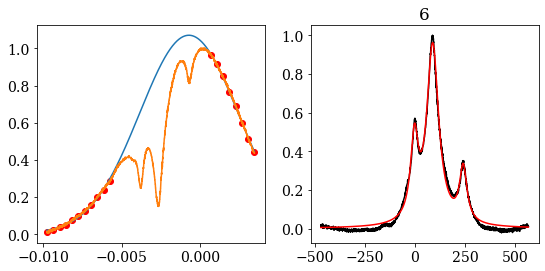

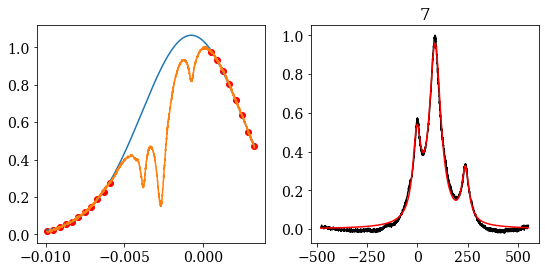

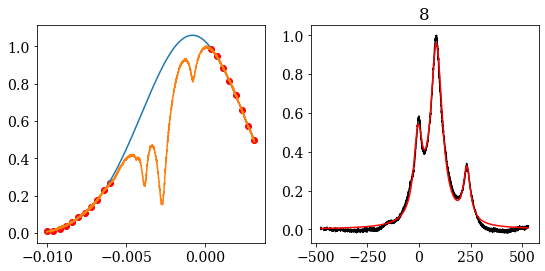

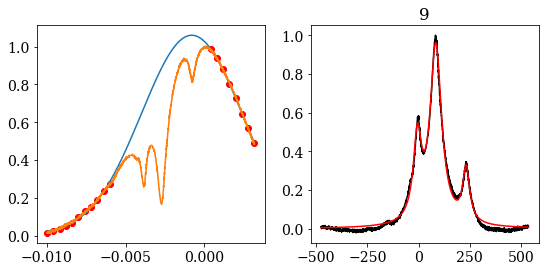

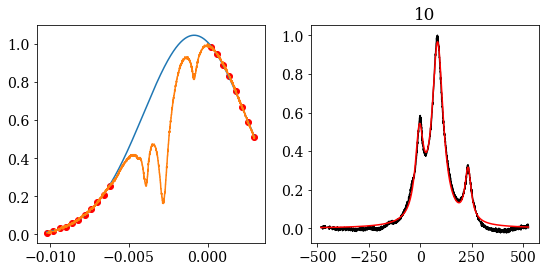

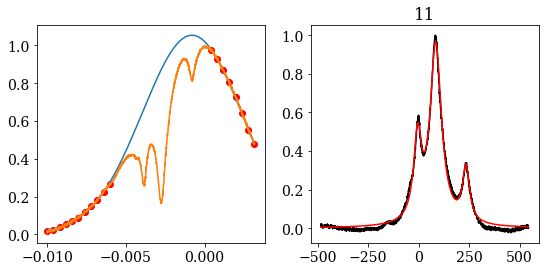

In [9]:
Gamma1 = []
for i in range(6, 12, 1):
    data = pd.read_csv("./data_saturation/scope_csv_{}.csv".format(i), skiprows=1)
    t, ch1, ch2 = data.iloc[::,0], data.iloc[::,1], data.iloc[::,2]
    t-= t[np.argmax(ch1)]
    ch1 -= ch1[100]
    ch1 /= np.max(ch1)
    
#     plt.subplot(221)
#     plt.plot(t, ch1, color='black')
    
    a, b = 700,4000
    x, y = np.array(t[a:b]), np.array(ch1[a:b])
    
    
    idx = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3290]
    
    try:
        popt, pcov = curve_fit(mode, x[idx], y[idx], p0=[0.004, -0.001, 1.0, -0.1])
    except RuntimeError:
        print(" o ")
        pass
    plt.figure(figsize=(9, 4))
    plt.subplot(121)
    plt.scatter(x[idx], y[idx], color="red")
    plt.plot(x, mode(x, *popt))
    plt.plot(x, y)
    
    
    plt.subplot(122)
    
    ch1_new = -y + mode(x, *popt)
    ch1_new /= np.max(ch1_new)
    t_new = x*1000*0.58/(popt[0]*np.sqrt(8*np.log(2)))
    peaks, _ = find_peaks(ch1_new, height=0.3, distance=150)
    t_new = t_new - t_new[peaks[0]]
    
    plt.plot(t_new, ch1_new, color="black")
    
    popt, pcov = curve_fit(lorenz_sum, t_new, ch1_new, p0=[10,0.55,0.0,   10,1.0,100,    10, 0.6,250])
    plt.plot(t_new, lorenz_sum(t_new, *popt), color="red")
    plt.title(i)

    
    g1, a1, m1, g2, a2, m2, g3, a3, m3 = popt
    
    Gamma1.append(g2)

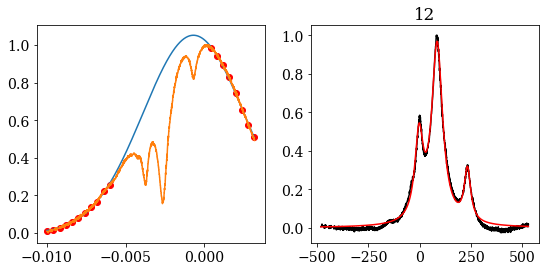

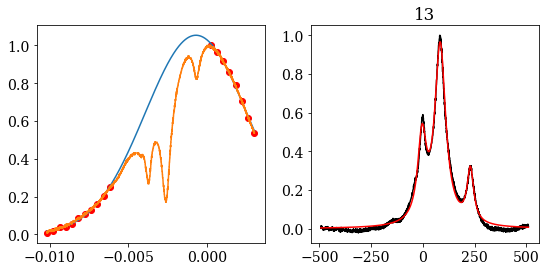

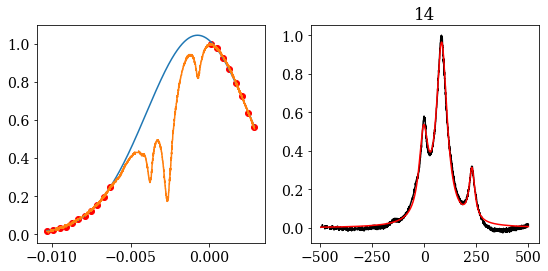

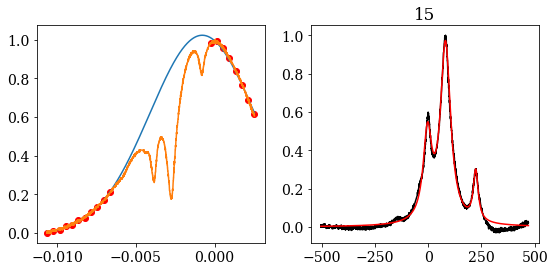

In [10]:
Gamma2 = []
for i in range(12, 16, 1):
    data = pd.read_csv("./data_saturation/scope_csv_{}.csv".format(i), skiprows=1)
    t, ch1, ch2 = data.iloc[::,0], data.iloc[::,1], data.iloc[::,2]
    t-= t[np.argmax(ch1)]
    ch1 -= ch1[100]
    ch1 /= np.max(ch1)
    
#     plt.subplot(221)
#     plt.plot(t, ch1, color='black')
    
    a, b = 700,4000
    x, y = np.array(t[a:b]), np.array(ch1[a:b])
    
    
    idx = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3290]
    
    try:
        popt, pcov = curve_fit(mode, x[idx], y[idx], p0=[0.004, -0.001, 1.0, -0.1])
    except RuntimeError:
        print(" o ")
        pass
    plt.figure(figsize=(9, 4))
    plt.subplot(121)
    plt.scatter(x[idx], y[idx], color="red")
    plt.plot(x, mode(x, *popt))
    plt.plot(x, y)
    
    
    plt.subplot(122)
    
    ch1_new = -y + mode(x, *popt)
    ch1_new /= np.max(ch1_new)
    t_new = x*1000*0.58/(popt[0]*np.sqrt(8*np.log(2)))
    peaks, _ = find_peaks(ch1_new, height=0.3, distance=150)
    t_new = t_new - t_new[peaks[0]]
    
    plt.plot(t_new, ch1_new, color="black")
    
    popt, pcov = curve_fit(lorenz_sum, t_new, ch1_new, p0=[10,0.55,0.0,   10,1.0,100,    10, 0.6,250])
    plt.plot(t_new, lorenz_sum(t_new, *popt), color="red")
    plt.title(i)

    
    g1, a1, m1, g2, a2, m2, g3, a3, m3 = popt
    
    Gamma2.append(g2)

75865.4074826202
74773.79660831473
74802.60980870311
72199.90984840259


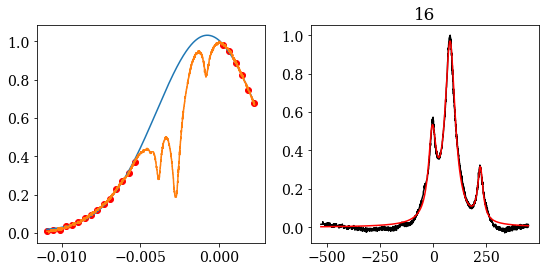

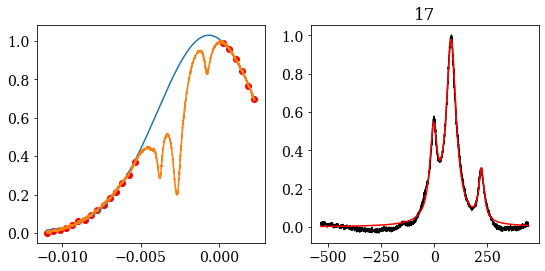

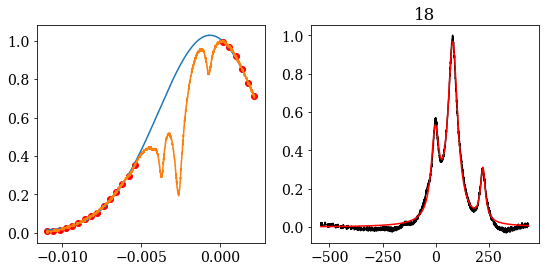

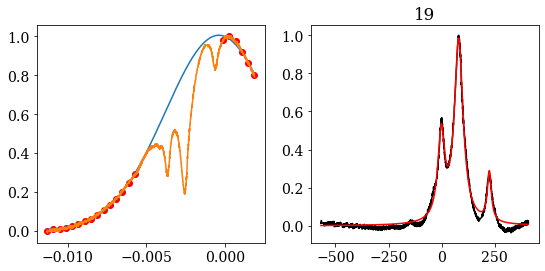

In [11]:
Gamma3 = []
for i in range(16, 20, 1):
    data = pd.read_csv("./data_saturation/scope_csv_{}.csv".format(i), skiprows=1)
    t, ch1, ch2 = data.iloc[::,0], data.iloc[::,1], data.iloc[::,2]
    t-= t[np.argmax(ch1)]
    ch1 -= ch1[100]
    ch1 /= np.max(ch1)
    
#     plt.subplot(221)
#     plt.plot(t, ch1, color='black')
    
    a, b = 700,4000
    x, y = np.array(t[a:b]), np.array(ch1[a:b])
    
    
    idx = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 2800, 2900, 3000, 3100, 3200, 3290]
    
    try:
        popt, pcov = curve_fit(mode, x[idx], y[idx], p0=[0.004, -0.001, 1.0, -0.1])
    except RuntimeError:
        print(" o ")
        pass
    plt.figure(figsize=(9, 4))
    plt.subplot(121)
    plt.scatter(x[idx], y[idx], color="red")
    plt.plot(x, mode(x, *popt))
    plt.plot(x, y)
    
    
    plt.subplot(122)
    
    ch1_new = -y + mode(x, *popt)
    ch1_new /= np.max(ch1_new)
#     t_new = x*1000*0.58/(popt[0]*np.sqrt(8*np.log(2)))
    t_new = x*74000
    print(1000*0.58/(popt[0]*np.sqrt(8*np.log(2))))
    peaks, _ = find_peaks(ch1_new, height=0.3, distance=150)
    t_new = t_new - t_new[peaks[0]]
    
    plt.plot(t_new, ch1_new, color="black")
    
    popt, pcov = curve_fit(lorenz_sum, t_new, ch1_new, p0=[10,0.55,0.0,   10,1.0,100,    10, 0.6,250])
    plt.plot(t_new, lorenz_sum(t_new, *popt), color="red")
    plt.title(i)

    
    g1, a1, m1, g2, a2, m2, g3, a3, m3 = popt
    
    Gamma3.append(g2)

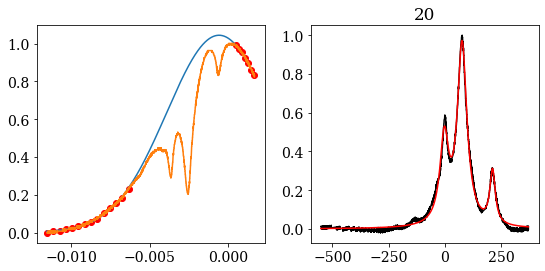

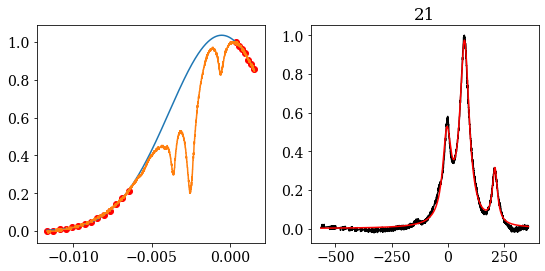

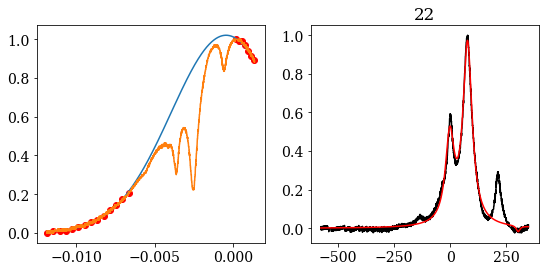

In [12]:
Gamma4 = []
for i in range(20, 23, 1):
    data = pd.read_csv("./data_saturation/scope_csv_{}.csv".format(i), skiprows=1)
    t, ch1, ch2 = data.iloc[::,0], data.iloc[::,1], data.iloc[::,2]
    t-= t[np.argmax(ch1)]
    ch1 -= ch1[100]
    ch1 /= np.max(ch1)
    
#     plt.subplot(221)
#     plt.plot(t, ch1, color='black')
    
    a, b = 700,4000
    x, y = np.array(t[a:b]), np.array(ch1[a:b])
    
    
    idx = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000,1100, 1200, 1300, 3000, 3050, 3100,3150, 3200,3250, 3290]
    
    try:
        popt, pcov = curve_fit(mode, x[idx], y[idx], p0=[0.004, -0.001, 1.0, -0.1])
    except RuntimeError:
        print(" o ")
        pass
    plt.figure(figsize=(9, 4))
    plt.subplot(121)
    plt.scatter(x[idx], y[idx], color="red")
    plt.plot(x, mode(x, *popt))
    plt.plot(x, y)
    
    
    plt.subplot(122)
    
    ch1_new = -y + mode(x, *popt)
    ch1_new /= np.max(ch1_new)
    t_new = x*70000
#     t_new = x*1000*0.58/(popt[0]*np.sqrt(8*np.log(2)))
    peaks, _ = find_peaks(ch1_new, height=0.3, distance=150)
    t_new = t_new - t_new[peaks[0]]
    
    plt.plot(t_new, ch1_new, color="black")
    
    popt, pcov = curve_fit(lorenz_sum, t_new, ch1_new, p0=[10,0.55,0.0,   10,1.0,100,    10, 0.6,250])
    plt.plot(t_new, lorenz_sum(t_new, *popt), color="red")
    plt.title(i)

    
    g1, a1, m1, g2, a2, m2, g3, a3, m3 = popt
    
    Gamma4.append(g2)

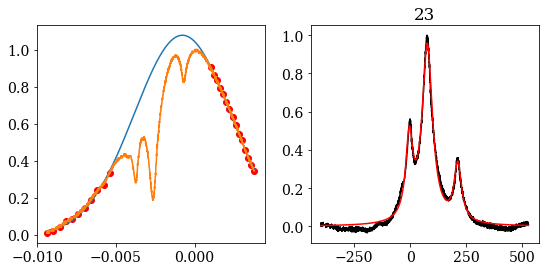

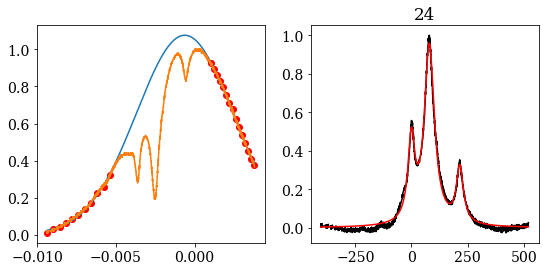

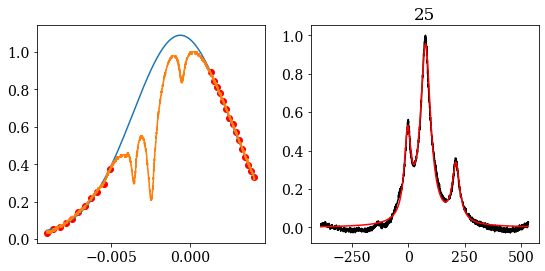

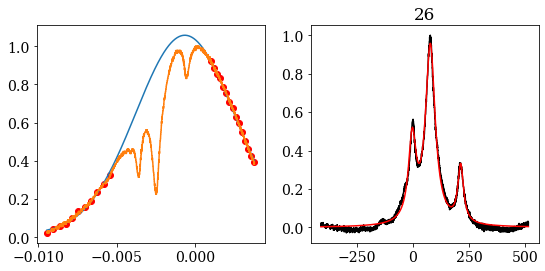

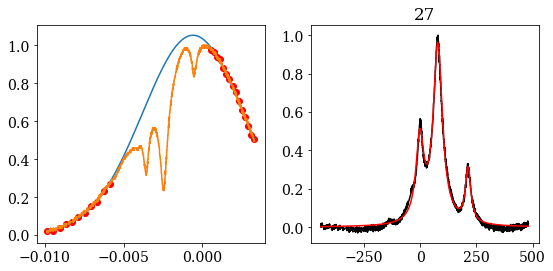

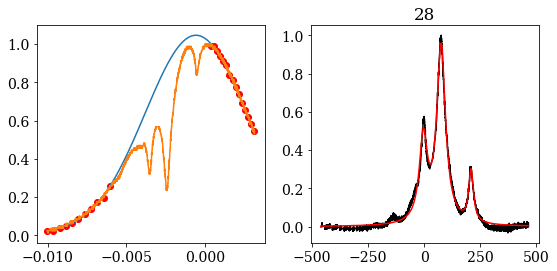

In [13]:
Gamma5 = []
for i in range(23, 29, 1):
    data = pd.read_csv("./data_saturation/scope_csv_{}.csv".format(i), skiprows=1)
    t, ch1, ch2 = data.iloc[::,0], data.iloc[::,1], data.iloc[::,2]
    t-= t[np.argmax(ch1)]
    ch1 -= ch1[100]
    ch1 /= np.max(ch1)
    
#     plt.subplot(221)
#     plt.plot(t, ch1, color='black')
    
    a, b = 700,4000
    x, y = np.array(t[a:b]), np.array(ch1[a:b])
    
    
    idx = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2600, 2650,2700,2750, 2800, 2850, 2900, 2950,3000, 3050,3100,3150, 3200,3250, 3290]
    
    try:
        popt, pcov = curve_fit(mode, x[idx], y[idx], p0=[0.004, -0.001, 1.0, -0.1])
    except RuntimeError:
        print(" o ")
        pass
    plt.figure(figsize=(9, 4))
    plt.subplot(121)
    plt.scatter(x[idx], y[idx], color="red")
    plt.plot(x, mode(x, *popt))
    plt.plot(x, y)
    
    
    plt.subplot(122)
    
    ch1_new = -y + mode(x, *popt)
    ch1_new /= np.max(ch1_new)
#     t_new = x*1000*0.58/(popt[0]*np.sqrt(8*np.log(2)))
    t_new = x*70000
    peaks, _ = find_peaks(ch1_new, height=0.3, distance=150)
    t_new = t_new - t_new[peaks[0]]
    
    plt.plot(t_new, ch1_new, color="black")
    
    popt, pcov = curve_fit(lorenz_sum, t_new, ch1_new, p0=[10,0.55,0.0,   10,1.0,100,    10, 0.6,250])
    plt.plot(t_new, lorenz_sum(t_new, *popt), color="red")
    plt.title(i)

    
    g1, a1, m1, g2, a2, m2, g3, a3, m3 = popt
    
    Gamma5.append(g2)

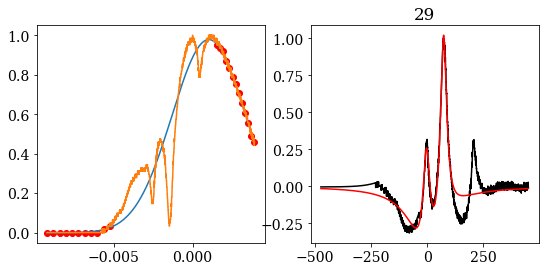

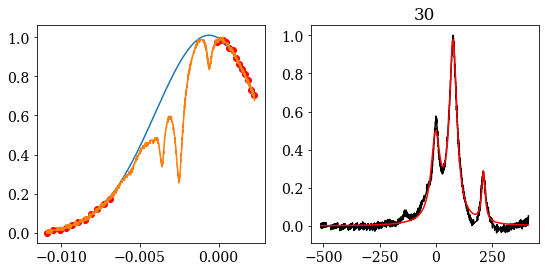

In [14]:
Gamma6 = []
for i in range(29, 31, 1):
    data = pd.read_csv("./data_saturation/scope_csv_{}.csv".format(i), skiprows=1)
    t, ch1, ch2 = data.iloc[::,0], data.iloc[::,1], data.iloc[::,2]
    t-= t[np.argmax(ch1)]
    ch1 -= ch1[100]
    ch1 /= np.max(ch1)
    
#     plt.subplot(221)
#     plt.plot(t, ch1, color='black')
    
    a, b = 700,4000
    x, y = np.array(t[a:b]), np.array(ch1[a:b])
    
    
    idx = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2700,2750, 2800,2850, 2900,2950, 3000,3050, 3100,3150, 3200, 3250,3290]
    
    try:
        popt, pcov = curve_fit(mode, x[idx], y[idx], p0=[0.004, -0.001, 1.0, -0.1])
    except RuntimeError:
        print(" o ")
        pass
    plt.figure(figsize=(9, 4))
    plt.subplot(121)
    plt.scatter(x[idx], y[idx], color="red")
    plt.plot(x, mode(x, *popt))
    plt.plot(x, y)
    
    
    plt.subplot(122)
    
    ch1_new = -y + mode(x, *popt)
    ch1_new /= np.max(ch1_new)
#     t_new = x*1000*0.58/(popt[0]*np.sqrt(8*np.log(2)))
    t_new = x*70000
    peaks, _ = find_peaks(ch1_new, height=0.3, distance=150)
    t_new = t_new - t_new[peaks[0]]
    
    plt.plot(t_new, ch1_new, color="black")
    
    popt, pcov = curve_fit(lorenz_sum, t_new, ch1_new, p0=[10,0.55,0.0,   10,1.0,100,    10, 0.6,250])
    plt.plot(t_new, lorenz_sum(t_new, *popt), color="red")
    plt.title(i)

    
    g1, a1, m1, g2, a2, m2, g3, a3, m3 = popt
    
    Gamma6.append(g2)

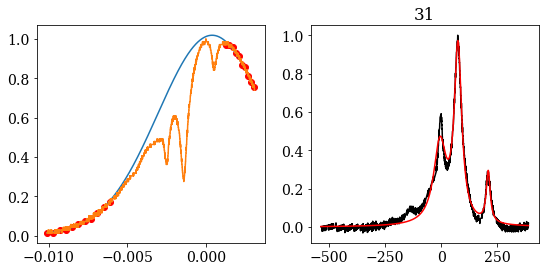

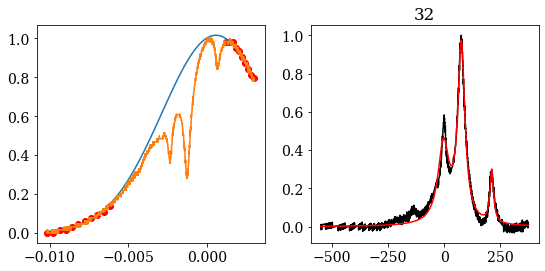

In [15]:
Gamma7 = []
for i in range(31, 33, 1):
    data = pd.read_csv("./data_saturation/scope_csv_{}.csv".format(i), skiprows=1)
    t, ch1, ch2 = data.iloc[::,0], data.iloc[::,1], data.iloc[::,2]
    t-= t[np.argmax(ch1)]
    ch1 -= ch1[100]
    ch1 /= np.max(ch1)
    
#     plt.subplot(221)
#     plt.plot(t, ch1, color='black')
    
    a, b = 700,4000
    x, y = np.array(t[a:b]), np.array(ch1[a:b])
    
    
    idx = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2850, 2900,2950, 3000,3050, 3100,3150, 3200, 3250,3290]
    
    try:
        popt, pcov = curve_fit(mode, x[idx], y[idx], p0=[0.004, -0.001, 1.0, -0.1])
    except RuntimeError:
        print(" o ")
        pass
    plt.figure(figsize=(9, 4))
    plt.subplot(121)
    plt.scatter(x[idx], y[idx], color="red")
    plt.plot(x, mode(x, *popt))
    plt.plot(x, y)
    
    
    plt.subplot(122)
    
    ch1_new = -y + mode(x, *popt)
    ch1_new /= np.max(ch1_new)
#     t_new = x*1000*0.58/(popt[0]*np.sqrt(8*np.log(2)))
    t_new = x*70000
    peaks, _ = find_peaks(ch1_new, height=0.3, distance=150)
    t_new = t_new - t_new[peaks[0]]
    
    plt.plot(t_new, ch1_new, color="black")
    
    popt, pcov = curve_fit(lorenz_sum, t_new, ch1_new, p0=[10,0.55,0.0,   10,1.0,100,    10, 0.6,250])
    plt.plot(t_new, lorenz_sum(t_new, *popt), color="red")
    plt.title(i)

    
    g1, a1, m1, g2, a2, m2, g3, a3, m3 = popt
    
    Gamma7.append(g2)

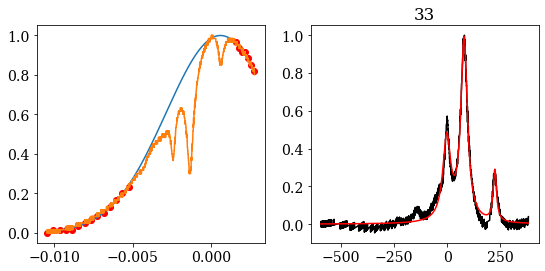

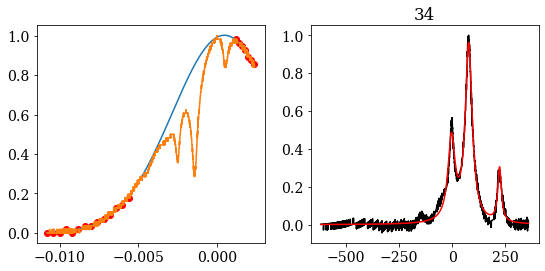

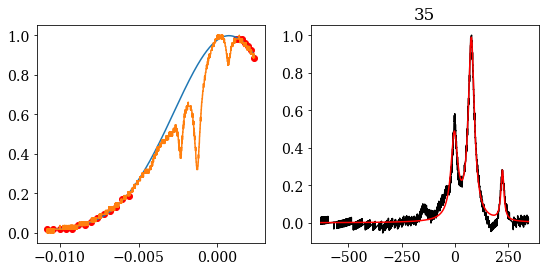

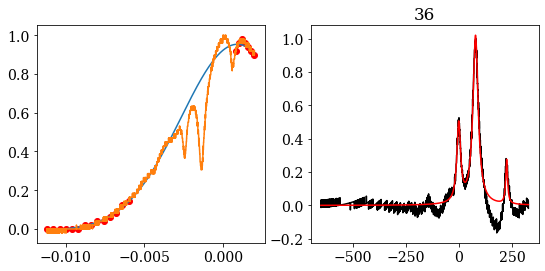

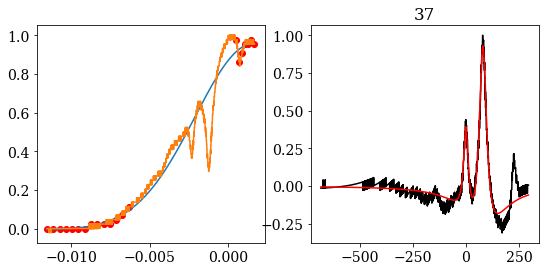

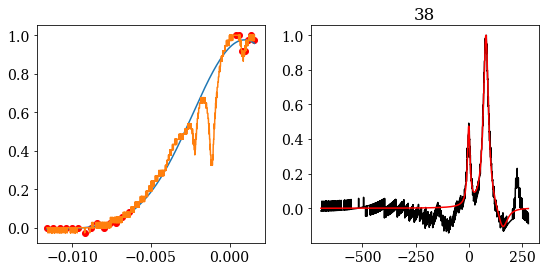

In [16]:
Gamma8 = []
for i in range(33, 39, 1):
    data = pd.read_csv("./data_saturation/scope_csv_{}.csv".format(i), skiprows=1)
    t, ch1, ch2 = data.iloc[::,0], data.iloc[::,1], data.iloc[::,2]
    t-= t[np.argmax(ch1)]
    ch1 -= ch1[100]
    ch1 /= np.max(ch1)
    
#     plt.subplot(221)
#     plt.plot(t, ch1, color='black')
    
    a, b = 700,4000
    x, y = np.array(t[a:b]), np.array(ch1[a:b])
    
    
    idx = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000,1100, 1200, 1300, 3000,3050, 3100,3150, 3200, 3250,3290]
    
    try:
        popt, pcov = curve_fit(mode, x[idx], y[idx], p0=[0.004, -0.001, 1.0, -0.1])
    except RuntimeError:
        print(" o ")
        pass
    plt.figure(figsize=(9, 4))
    plt.subplot(121)
    plt.scatter(x[idx], y[idx], color="red")
    plt.plot(x, mode(x, *popt))
    plt.plot(x, y)
    
    
    plt.subplot(122)
    
    ch1_new = -y + mode(x, *popt)
    ch1_new /= np.max(ch1_new)
#     t_new = x*1000*0.58/(popt[0]*np.sqrt(8*np.log(2)))
    t_new = x*74000
    peaks, _ = find_peaks(ch1_new, height=0.3, distance=150)
    t_new = t_new - t_new[peaks[0]]
    
    plt.plot(t_new, ch1_new, color="black")
    
    popt, pcov = curve_fit(lorenz_sum, t_new, ch1_new, p0=[10,0.55,0.0,   10,1.0,100,    10, 0.6,250])
    plt.plot(t_new, lorenz_sum(t_new, *popt), color="red")
    plt.title(i)

    
    g1, a1, m1, g2, a2, m2, g3, a3, m3 = popt
    
    Gamma8.append(g2)

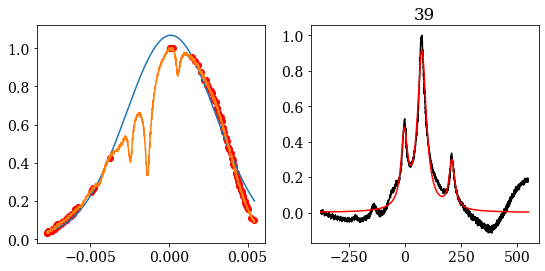

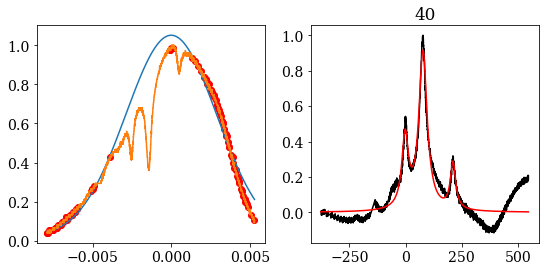

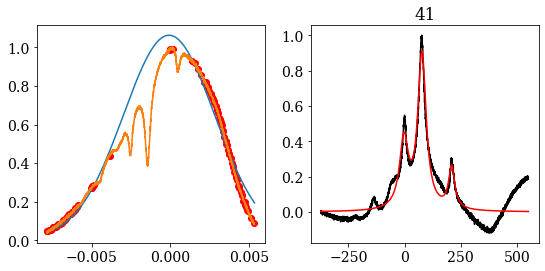

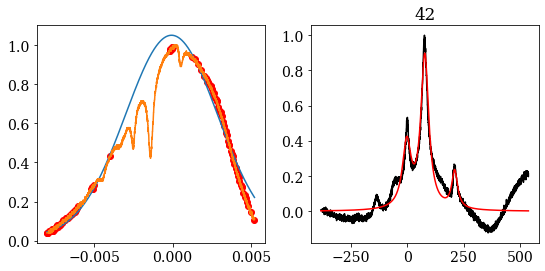

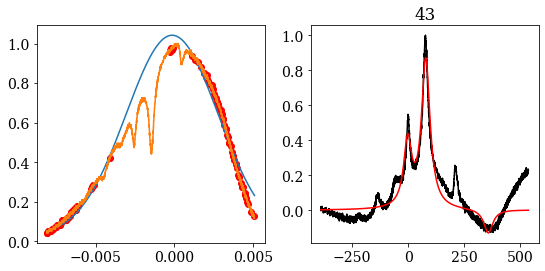

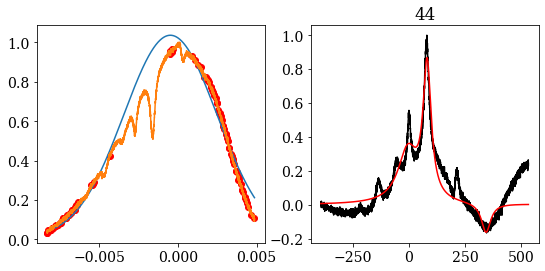

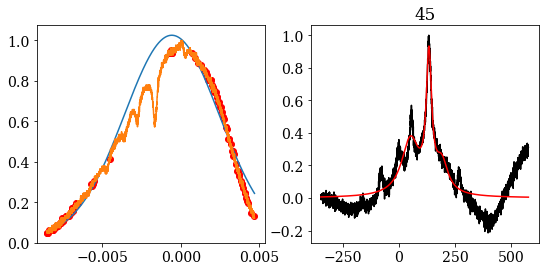

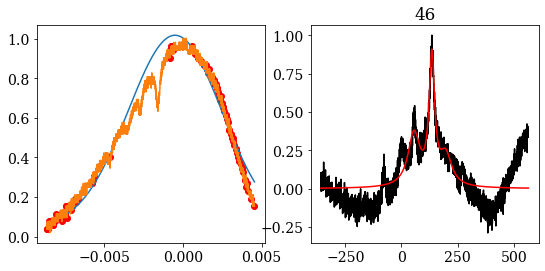

In [17]:
Gamma9 = []
for i in range(39, 47, 1):
    data = pd.read_csv("./data_saturation/scope_csv_{}.csv".format(i), skiprows=1)
    t, ch1, ch2 = data.iloc[::,0], data.iloc[::,1], data.iloc[::,2]
    t-= t[np.argmax(ch1)]
    ch1 -= ch1[100]
    ch1 /= np.max(ch1)
    
#     plt.subplot(221)
#     plt.plot(t, ch1, color='black')
    
    a, b = 700,4000
    x, y = np.array(t[a:b]), np.array(ch1[a:b])
    
    
    idx = [0, 100,150, 200, 250, 300, 350, 400, 450, 500, 700,710, 720, 730, 750, 1000, 1950, 1960, 1970, 1980, 1990, 2000, 2300, 2350,2400, 
           2450, 2500,2550, 2600, 2650, 
           2700,2750, 2800, 2850, 2900, 2950, 3000,3050, 3100,3150, 3200, 3250,3290]
    
    idx = np.append(idx, np.arange(2500, 3200, 20))
    idx = np.append(idx, np.arange(0, 500, 20))
    
    try:
        popt, pcov = curve_fit(mode, x[idx], y[idx], p0=[0.004, -0.001, 1.0, -0.1])
    except RuntimeError:
        print(" o ")
        pass
    plt.figure(figsize=(9, 4))
    plt.subplot(121)
    plt.scatter(x[idx], y[idx], color="red")
    plt.plot(x, mode(x, *popt))
    plt.plot(x, y)
    
    
    plt.subplot(122)
    
    ch1_new = -y + mode(x, *popt)
    ch1_new /= np.max(ch1_new)
#     t_new = x*1000*0.58/(popt[0]*np.sqrt(8*np.log(2)))
    t_new = x*70000
    peaks, _ = find_peaks(ch1_new, height=0.3, distance=150)
    t_new = t_new - t_new[peaks[0]]
    
    plt.plot(t_new, ch1_new, color="black")
    
    popt, pcov = curve_fit(lorenz_sum, t_new, ch1_new, p0=[10,0.55,0.0,   10,1.0,100,    10, 0.6,250])
    plt.plot(t_new, lorenz_sum(t_new, *popt), color="red")
    plt.title(i)

    
    g1, a1, m1, g2, a2, m2, g3, a3, m3 = popt
    
    Gamma9.append(g2)

[15.13652628  1.78043445]
15.136526282548225 1.7804344455998404


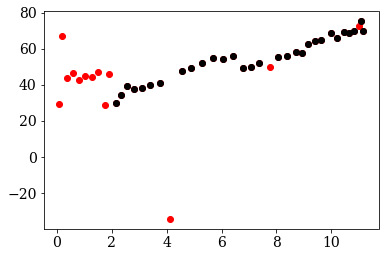

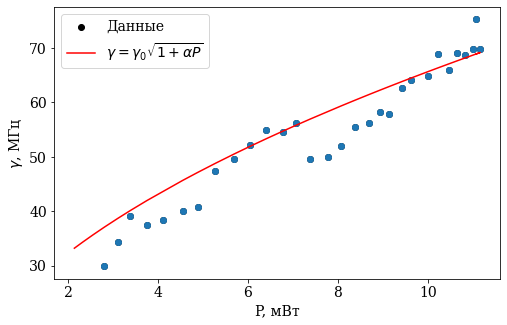

In [18]:
temp_gamma = [Gamma0, Gamma1, Gamma2, Gamma3, Gamma4, Gamma5,
        Gamma6, Gamma7, Gamma8, Gamma9]

Gamma = []
for temp_list in temp_gamma:
  for el in temp_list:
    Gamma.append(el)
    
Gamma = np.array(Gamma)
    
P = np.array(power[:len(Gamma)])

plt.scatter(P, Gamma, color="red")
idx = np.arange(0, len(Gamma), 1)
idx = np.array(idx, dtype=np.int32)

idx = np.delete(idx, [ 2, 15, 25, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33])

Gamma = Gamma[idx]
P = P[idx]
plt.scatter(P, Gamma, color="black")

def sat_curve(x, g0, k):
    return g0 * np.sqrt(1 + k*(x))


popt, pcov = curve_fit(sat_curve, P, Gamma, p0=[6.06, 2.0])


plt.figure(figsize=(8, 5))
plt.scatter(power[:len(Gamma)], Gamma, color="black", label="Данные")
plt.plot(P, sat_curve(P, *popt), color="red", 
         label="$\\gamma = \\gamma_0 \\sqrt{1 + \\alpha P}$")
plt.xlabel("P, мВт")
plt.ylabel("$\gamma$, МГц")

# plt.annotate(xy=(7, 35), text="$\\gamma_0 = ({}\pm{})$ МГц \n".format(round(g,1), round(sg,1)) + "$k = ({}\pm{})$ 1/мВт \n".format(round(k,1), round(sk,1)))

print(popt)
# sg, sk = (pcov[0][0])**0.5, (pcov[1][1])**0.5
g, k = popt
print(g, k)
# plt.fill_between(P, sat_curve(P, g-sg, k-sk), sat_curve(P, g+sg, k+sk), color="red", alpha=0.2)
plt.legend()


plt.scatter(power[:len(Gamma)], Gamma)

### 4 - 14 все ок

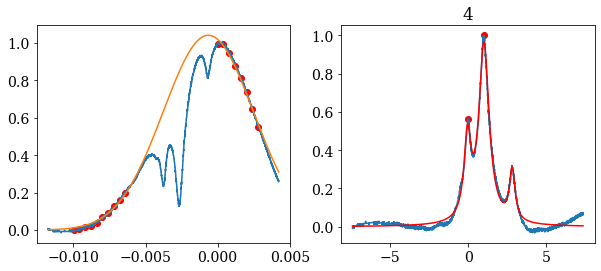

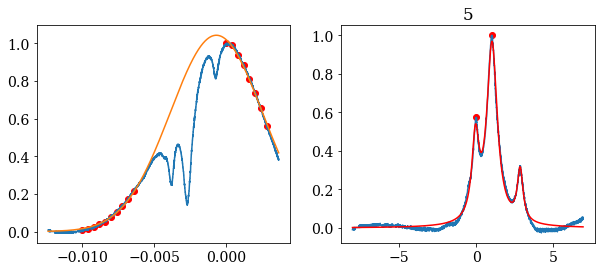

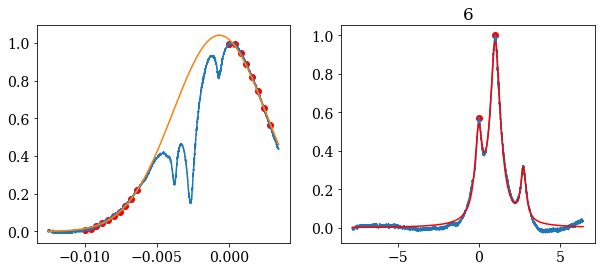

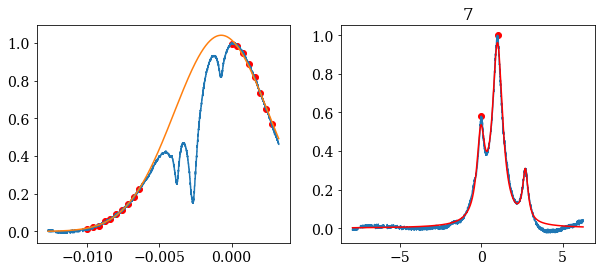

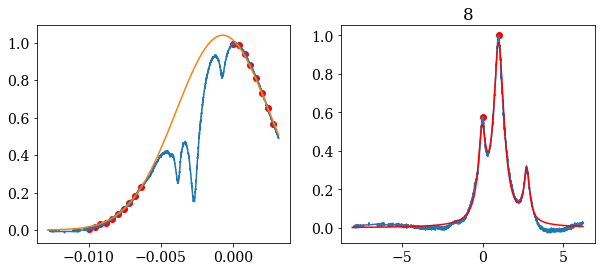

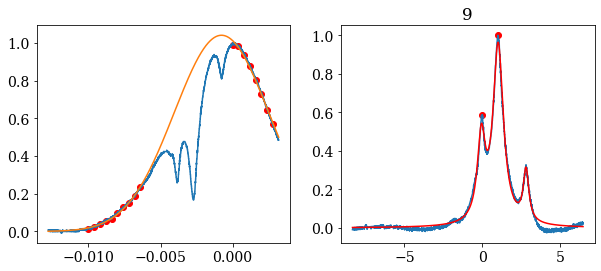

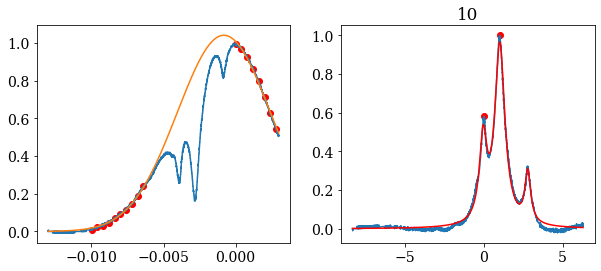

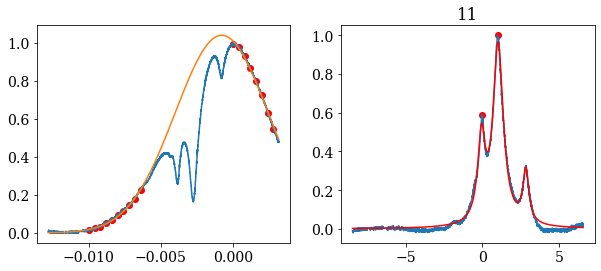

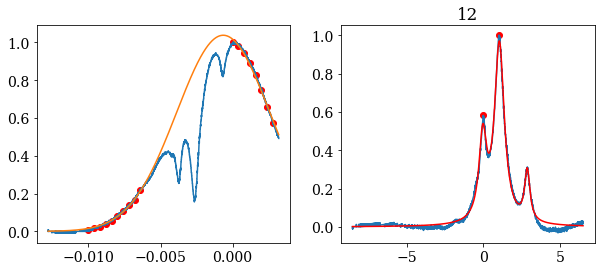

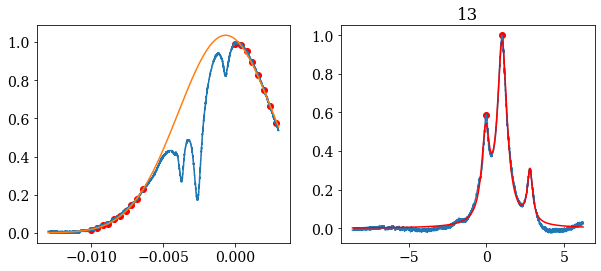

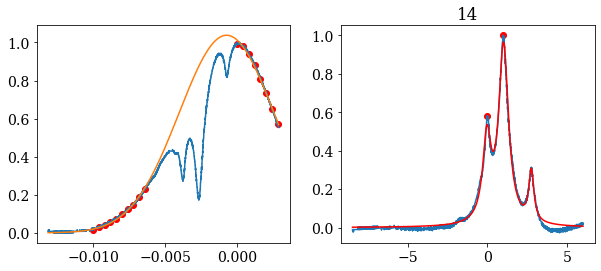

In [19]:
Gamma = []
for i in range(4, 15, 1):
    data = pd.read_csv("./data_saturation/scope_csv_{}.csv".format(i), skiprows=1)
    t, ch1, ch2 = data.iloc[::,0], data.iloc[::,1], data.iloc[::,2]
    t-= t[np.argmax(ch1)]
    ch1 -= ch1[100]
    ch1 /= np.max(ch1)
    t, ch1 = np.array(t), np.array(ch1)
    

    ab = np.intersect1d(np.argwhere(t > -0.01), np.argwhere(t < 0.05))
    x, y = t[ab], ch1[ab]
    
    
    res = convex_floor(x, y)
    temp_x, temp_y = res[0]
    idx = [0, 100, 200, 300, 400, 500, 600,700, 800, 900, 3200, 3100, 3000, 2900, 2800, 2700, 2600, 2500]
    
    plt.figure(figsize=(10,4))
    plt.subplot(121)
    x, y = np.array(x), np.array(y)
    plt.scatter(x[idx], y[idx], color="red")
    plt.plot(t, ch1)
    
    try:
        popt, pcov = curve_fit(mode0, x[idx], y[idx], p0=[0.004, -0.001, 1.0])
        plt.plot(t, mode0(t, *popt))
    except RuntimeError:
        print(" o ")
        pass

    
    plt.subplot(122)
    ch1_new = -ch1 + mode0(t, *popt)
    ch1_new /= np.max(ch1_new)
    t_new = 1000*0.58/(popt[0]*np.sqrt(8*np.log(2)))
    peaks, _ = find_peaks(ch1_new, height=0.3, distance=150)
    t_new = t - t[peaks[0]]
    t_new /= t_new[peaks[1]]
    
    plt.plot(t_new, ch1_new)
    c, d = -1, 4
    
    temp_idx = np.intersect1d(np.argwhere(t_new > c), np.argwhere(t_new < d))
    t_x, t_y = t_new[temp_idx], ch1_new[temp_idx]
#     plt.plot(t_new, ch1_new, color="orange")
    
    
    peaks, _ = find_peaks(t_y, distance=200, height=0.4)
    plt.scatter(t_x[peaks], t_y[peaks], color="red")
    plt.title(i)
#     print(t_new[peaks])
    popt, pcov = curve_fit(lorenz_sum, t_x, t_y, p0=[0.8,0.55,0.0,   0.8,1.0,1.55,    0.8, 0.6,2.8])
    plt.plot(t_new, lorenz_sum(t_new, *popt), color="red")

    
    g1, a1, m1, g2, a2, m2, g3, a3, m3 = popt
    
    Gamma.append(g2)

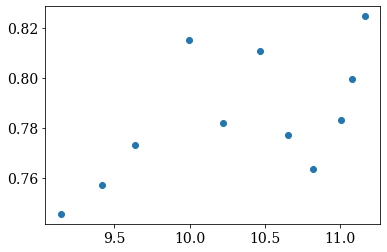

In [20]:
plt.scatter(power[:len(Gamma)], Gamma)

### 15 - 29 без 22, 29

[   0   15   85 1815 2123 2149 2499 2504 2550 2589 2612 2631 2668 2738
 2792 2858 2907 3043 3074 3118 3125 3131]
[   0   15 2589 2612 2631 2668 2738 2792 2858 2907 3043 3074 3118 3125
 3131]
[   0   12  107 1821 2137 2162 2499 2515 2565 2593 2688 2715 2768 2807
 2879 2947 3043 3062 3063]
[   0   12 2593 2688 2715 2768 2807 2879 2947 3043 3062 3063]
[   0    3   29 1834 2156 2499 2555 2615 2642 2744 2789 2871 2917 2971
 3003 3053 3055]
[   0    3 2744 2789 2871 2917 2971 3003 3053 3055]
[   0    3   25 1846 2159 2180 2499 2567 2600 2658 2682 2702 2763 2803
 2829 2867 2929 3010 3033 3048 3050]
[   0    3 2658 2682 2702 2763 2803 2829 2867 2929 3010 3033 3048 3050]
[   0   13   91 1858 2176 2499 2599 2689 2724 2821 2877 2932 2945 2956
 2966]
[   0   13 2821 2877 2932 2945 2956 2966]
[   0    4   59 1861 2168 2499 2594 2640 2685 2745 2811 2908 2912]
[   0    4 2745 2811 2908 2912]
[   0   83 1864 2176 2213 2499 2614 2640 2665 2710 2855 2876 2881]
[   0   83 2710 2855 2876 2881]
[   0    6 

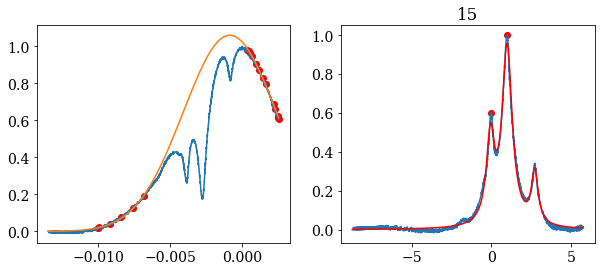

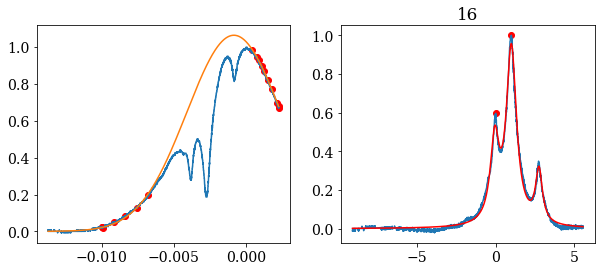

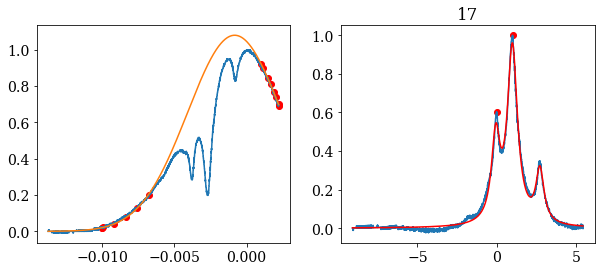

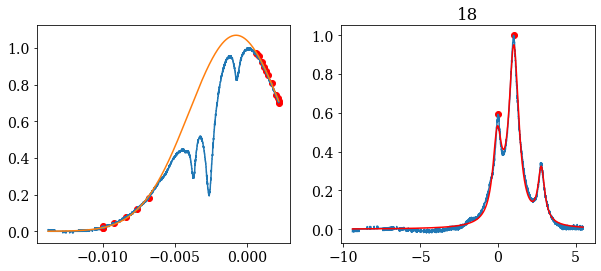

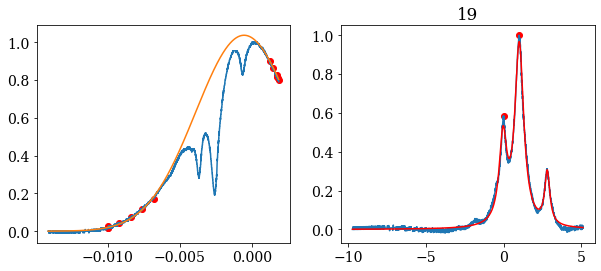

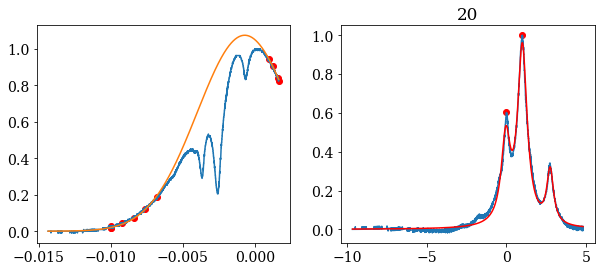

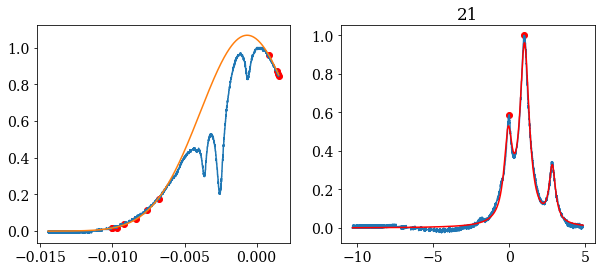

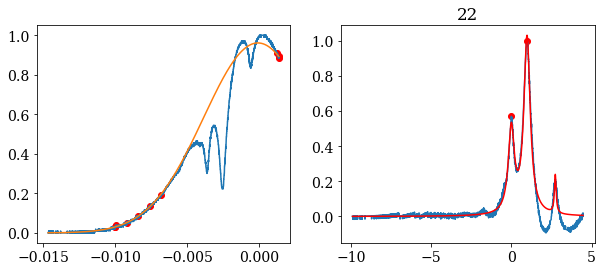

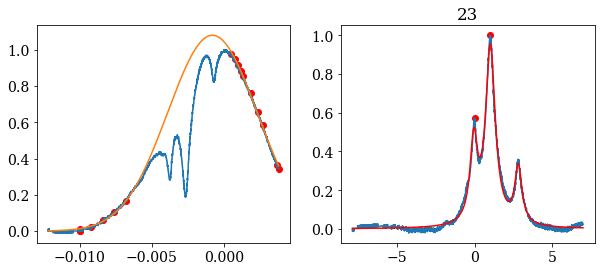

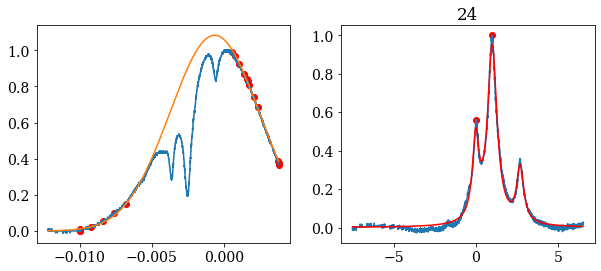

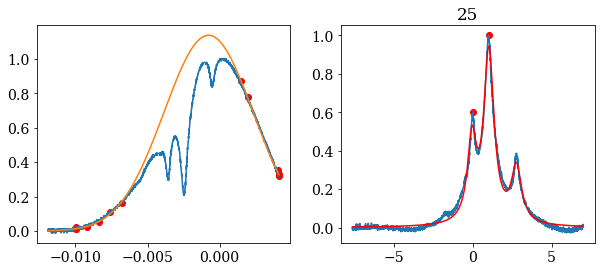

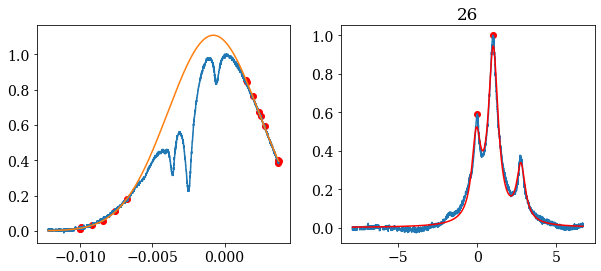

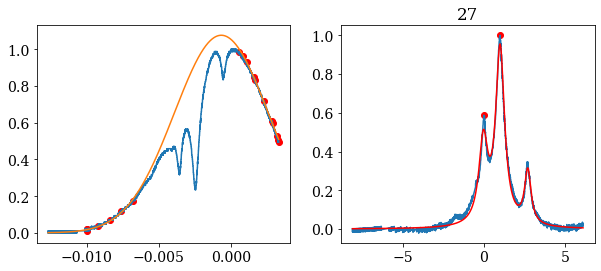

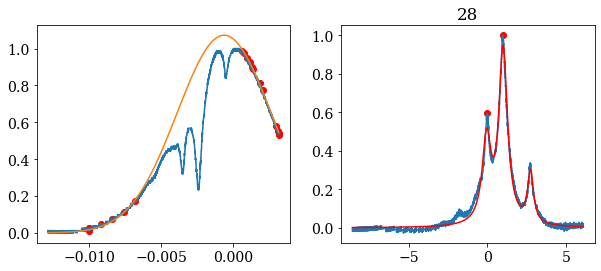

In [21]:
Gamma1 = []
for i in range(15, 29, 1):
    data = pd.read_csv("./data_saturation/scope_csv_{}.csv".format(i), skiprows=1)
    t, ch1, ch2 = data.iloc[::,0], data.iloc[::,1], data.iloc[::,2]
    t-= t[np.argmax(ch1)]
    ch1 -= ch1[100]
    ch1 /= np.max(ch1)
    t, ch1 = np.array(t), np.array(ch1)
    

    ab = np.intersect1d(np.argwhere(t > -0.01), np.argwhere(t < 0.05))
    x, y = t[ab], ch1[ab]
    
    
    res = convex_floor(x, y)
    temp_x, temp_y = res[0]
    idx = np.sort(res[1][1])
    print(idx)
    idx = np.delete(idx, [2, 3, 4,5 , 6, 7, 8])
    print(idx)
    idx = np.append(idx, idx[0] + np.arange(0, 1000, 200))
#     idx = np.sort(idx)
#     idx = np.delete(idx, [0, 1, 2, 3])
    
    
    plt.figure(figsize=(10,4))
    plt.subplot(121)
    plt.scatter(x[idx], y[idx], color="red")
    plt.plot(t, ch1)
    
    try:
        popt, pcov = curve_fit(mode0, x[idx], y[idx], p0=[0.004, -0.001, 1.0])
        plt.plot(t, mode0(t, *popt))
    except RuntimeError:
        print(" o ")
        pass
    

    
    plt.subplot(122)
    ch1_new = -ch1 + mode0(t, *popt)
    ch1_new /= np.max(ch1_new)
    t_new = 1000*0.58/(popt[0]*np.sqrt(8*np.log(2)))
    peaks, _ = find_peaks(ch1_new, height=0.3, distance=150)
    t_new = t - t[peaks[0]]
    t_new /= t_new[peaks[1]]
    
    plt.plot(t_new, ch1_new)
    c, d = -1, 4
    
    temp_idx = np.intersect1d(np.argwhere(t_new > c), np.argwhere(t_new < d))
    t_x, t_y = t_new[temp_idx], ch1_new[temp_idx]
#     plt.plot(t_new, ch1_new, color="orange")
    
    
    peaks, _ = find_peaks(t_y, distance=200, height=0.4)
    plt.scatter(t_x[peaks], t_y[peaks], color="red")
    plt.title(i)
#     print(t_new[peaks])
    popt, pcov = curve_fit(lorenz_sum, t_x, t_y, p0=[0.8,0.55,0.0,   0.8,1.0,1.55,    0.8, 0.6,2.8])
    plt.plot(t_new, lorenz_sum(t_new, *popt), color="red")

    
    g1, a1, m1, g2, a2, m2, g3, a3, m3 = popt
    

    Gamma1.append(g2)

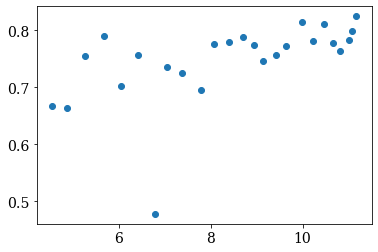

In [22]:
G = np.append(Gamma, Gamma1)
plt.scatter(power[:len(G)], G)

### 30 - 34

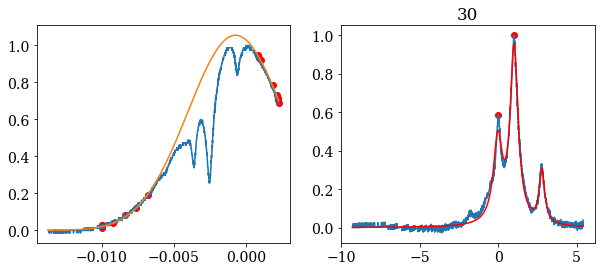

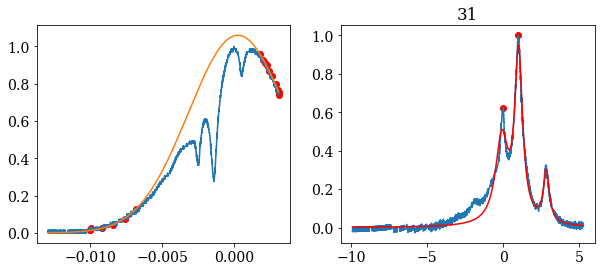

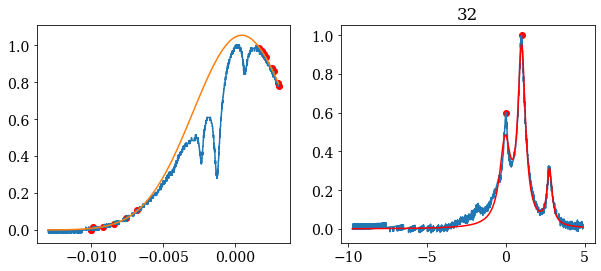

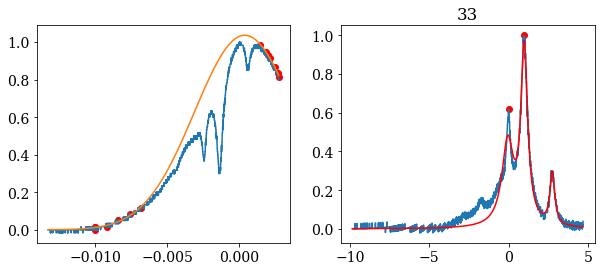

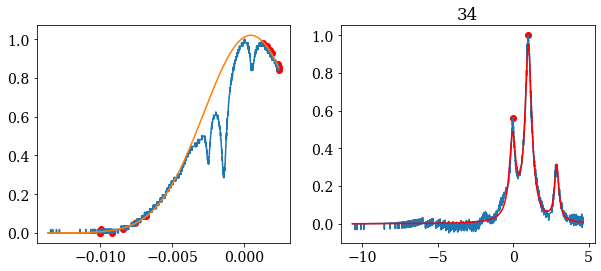

In [23]:
Gamma2 = []
for i in range(30, 35, 1):
    data = pd.read_csv("./data_saturation/scope_csv_{}.csv".format(i), skiprows=1)
    t, ch1, ch2 = data.iloc[::,0], data.iloc[::,1], data.iloc[::,2]
    t-= t[np.argmax(ch1)]
    ch1 -= ch1[100]
    ch1 /= np.max(ch1)
    t, ch1 = np.array(t), np.array(ch1)
    

    ab = np.intersect1d(np.argwhere(t > -0.01), np.argwhere(t < 0.05))
    x, y = t[ab], ch1[ab]
    
    
    res = convex_floor(x, y)
    temp_x, temp_y = res[0]
    idx = np.sort(res[1][1])
#     print(idx)
    idx = np.delete(idx, [2, 3, 4,5 , 6, 7, 8])
#     print(idx)
    idx = np.append(idx, idx[0] + np.arange(0, 1000, 200))
#     idx = np.sort(idx)
#     idx = np.delete(idx, [0, 1, 2, 3])
    
    
    plt.figure(figsize=(10,4))
    plt.subplot(121)
    plt.scatter(x[idx], y[idx], color="red")
    plt.plot(t, ch1)
    
    try:
        popt, pcov = curve_fit(mode0, x[idx], y[idx], p0=[0.004, -0.001, 1.0])
        plt.plot(t, mode0(t, *popt))
    except RuntimeError:
        print(" o ")
        pass
    

    
    plt.subplot(122)
    ch1_new = -ch1 + mode0(t, *popt)
    ch1_new /= np.max(ch1_new)
    t_new = 1000*0.58/(popt[0]*np.sqrt(8*np.log(2)))
    peaks, _ = find_peaks(ch1_new, height=0.3, distance=150)
    t_new = t - t[peaks[0]]
    t_new /= t_new[peaks[1]]
    
    plt.plot(t_new, ch1_new)
    c, d = -1, 4
    
    temp_idx = np.intersect1d(np.argwhere(t_new > c), np.argwhere(t_new < d))
    t_x, t_y = t_new[temp_idx], ch1_new[temp_idx]
#     plt.plot(t_new, ch1_new, color="orange")
    
    
    peaks, _ = find_peaks(t_y, distance=200, height=0.4)
    plt.scatter(t_x[peaks], t_y[peaks], color="red")
    plt.title(i)
#     print(t_new[peaks])
    popt, pcov = curve_fit(lorenz_sum, t_x, t_y, p0=[0.8,0.55,0.0,   0.8,1.0,1.55,    0.8, 0.6,2.8])
    plt.plot(t_new, lorenz_sum(t_new, *popt), color="red")

    
    g1, a1, m1, g2, a2, m2, g3, a3, m3 = popt
    

    Gamma2.append(g2)

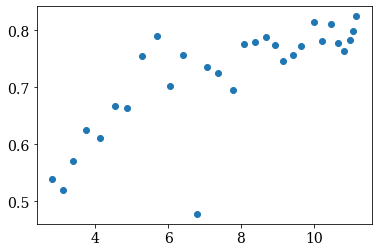

In [24]:
G = np.append(G, Gamma2)
plt.scatter(power[:len(G)], G)

### 35 - 

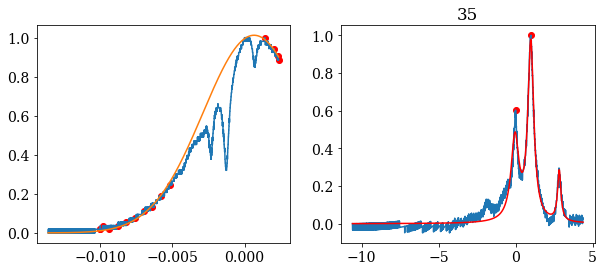

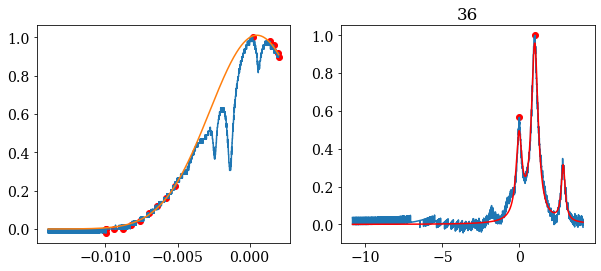

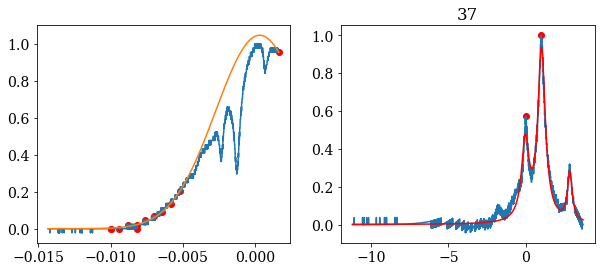

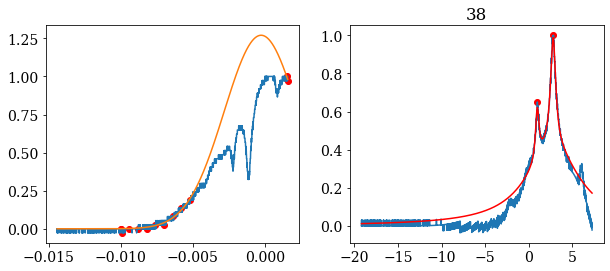

In [25]:
Gamma3 = []
for i in range(35, 39, 1):
    data = pd.read_csv("./data_saturation/scope_csv_{}.csv".format(i), skiprows=1)
    t, ch1, ch2 = data.iloc[::,0], data.iloc[::,1], data.iloc[::,2]
    t-= t[np.argmax(ch1)]
    ch1 -= ch1[100]
    ch1 /= np.max(ch1)
    t, ch1 = np.array(t), np.array(ch1)
    

    ab = np.intersect1d(np.argwhere(t > -0.01), np.argwhere(t < 0.05))
    x, y = t[ab], ch1[ab]
    
    
    res = convex_floor(x, y)
    temp_x, temp_y = res[0]
    idx = np.sort(res[1][1])
#     print(idx)
    idx = np.delete(idx, [2, 3, 4,5 , 6])
#     print(idx)
    idx = np.append(idx, idx[0] + np.arange(0, 1300, 150))
#     idx = np.sort(idx)
#     idx = np.delete(idx, [0, 1, 2, 3])
    
    
    plt.figure(figsize=(10,4))
    plt.subplot(121)
    plt.scatter(x[idx], y[idx], color="red")
    plt.plot(t, ch1)
    
    try:
        popt, pcov = curve_fit(mode0, x[idx], y[idx], p0=[0.004, -0.001, 1.0])
        plt.plot(t, mode0(t, *popt))
    except RuntimeError:
        print(" o ")
        pass
    

    
    plt.subplot(122)
    ch1_new = -ch1 + mode0(t, *popt)
    ch1_new /= np.max(ch1_new)
    t_new =1000* 0.58/(popt[0]*np.sqrt(8*np.log(2)))
    peaks, _ = find_peaks(ch1_new, height=0.3, distance=150)
    t_new = t - t[peaks[0]]
    t_new /= t_new[peaks[1]]
    
    plt.plot(t_new, ch1_new)
    c, d = -1, 4
    
    temp_idx = np.intersect1d(np.argwhere(t_new > c), np.argwhere(t_new < d))
    t_x, t_y = t_new[temp_idx], ch1_new[temp_idx]
#     plt.plot(t_new, ch1_new, color="orange")
    
    
    peaks, _ = find_peaks(t_y, distance=200, height=0.4)
    plt.scatter(t_x[peaks], t_y[peaks], color="red")
    plt.title(i)
#     print(t_new[peaks])
    popt, pcov = curve_fit(lorenz_sum, t_x, t_y, p0=[0.8,0.55,0.0,   0.8,1.0,1.55,    0.8, 0.6,2.8])
    plt.plot(t_new, lorenz_sum(t_new, *popt), color="red")

    
    g1, a1, m1, g2, a2, m2, g3, a3, m3 = popt
    

    Gamma3.append(g2)

In [26]:
def lorenz_sum1(x, g1, a1, m1, g2, a2, m2, g3, a3, m3, g4, a4, m4):
    return lorenz(x, g1, a1, m1) + lorenz(x, g2, a2, m2) + lorenz(x, g3, a3, m3) + lorenz(x, g4, a4, m4)

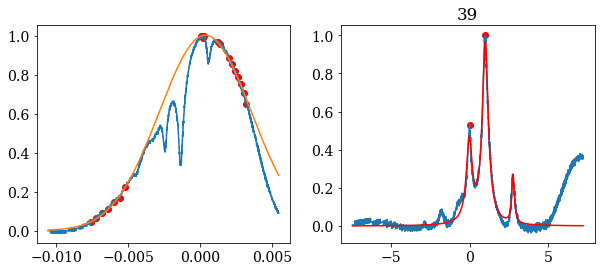

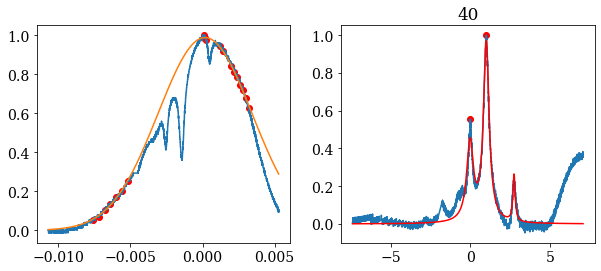

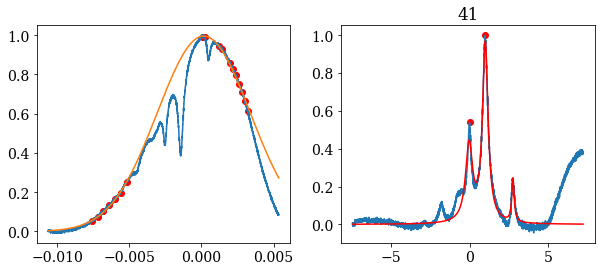

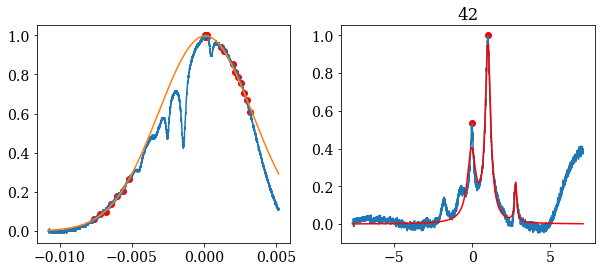

In [27]:
Gamma4 = []
for i in range(39, 43, 1):
    data = pd.read_csv("./data_saturation/scope_csv_{}.csv".format(i), skiprows=1)
    t, ch1, ch2 = data.iloc[::,0], data.iloc[::,1], data.iloc[::,2]
    t-= t[np.argmax(ch1)]
    ch1 -= ch1[100]
    ch1 /= np.max(ch1)
    t, ch1 = np.array(t), np.array(ch1)
    

    ab = np.intersect1d(np.argwhere(t > -0.008), np.argwhere(t < 0.0035))
    x, y = t[ab], ch1[ab]
    
    
#     res = convex_floor(x, y)
#     temp_x, temp_y = res[0]
#     idx = np.sort(res[1][1])
# #     print(idx)
#     idx = np.delete(idx, [2,3,4,5])
# #     print(idx)
#     idx = np.append(idx, idx[0] + np.arange(0, 800, 150))
#     idx = np.sort(idx)
# #     idx = np.append(idx, idx[-1] + np.arange(0, 200, 150))
   
#     idx = np.delete(idx, [0, 1, 2, 3])

    idx = [100, 200, 300, 400, 500, 600, 700, 2020, 2030, 2040, 2050, 2060, 2300, 2350, 2500, 2600, 2700, 2800, 2650, 2750, 2550]
    
    
    plt.figure(figsize=(10,4))
    plt.subplot(121)
    plt.scatter(x[idx], y[idx], color="red")
    plt.plot(t, ch1)
    
    try:
        popt, pcov = curve_fit(mode0, x[idx], y[idx], p0=[0.004, -0.001, 1.0])
        plt.plot(t, mode0(t, *popt))
    except RuntimeError:
        print(" o ")
        pass
    

    
    plt.subplot(122)
    ch1_new = -ch1 + mode0(t, *popt)
    ch1_new /= np.max(ch1_new)
    t_new = 1000 * 0.58/(popt[0]*np.sqrt(8*np.log(2)))
    peaks, _ = find_peaks(ch1_new, height=0.3, distance=150)
    t_new = t - t[peaks[0]]
    t_new /= t_new[peaks[1]]
    
    plt.plot(t_new, ch1_new)
    c, d = -1, 4
    
    temp_idx = np.intersect1d(np.argwhere(t_new > c), np.argwhere(t_new < d))
    t_x, t_y = t_new[temp_idx], ch1_new[temp_idx]
#     plt.plot(t_new, ch1_new, color="orange")
    
    
    peaks, _ = find_peaks(t_y, distance=200, height=0.4)
    plt.scatter(t_x[peaks], t_y[peaks], color="red")
    plt.title(i)
#     print(t_new[peaks])
    popt, pcov = curve_fit(lorenz_sum, t_x, t_y, p0=[ 0.8,0.55,0.0,   0.8,1.0,1.55,    0.8, 0.6,2.8])
    plt.plot(t_new, lorenz_sum(t_new, *popt), color="red")

    
    g1, a1, m1, g2, a2, m2, g3, a3, m3 = popt
    

    Gamma4.append(g2)

In [28]:
G = np.append(G, Gamma3)
G = np.append(G, Gamma4)

38


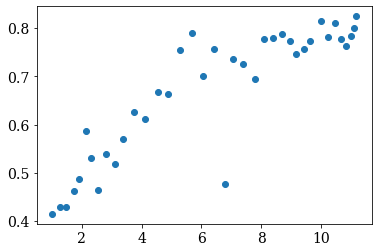

In [29]:
# plt.scatter(power[:len(G)], G)
print(len(G))
plt.scatter(power[:len(G)], G)

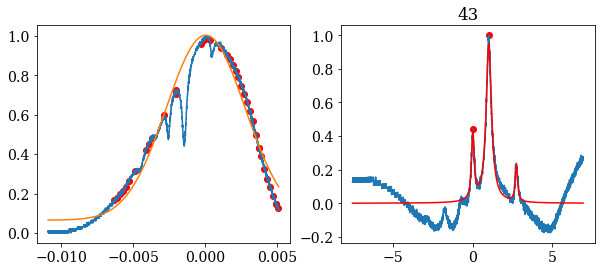

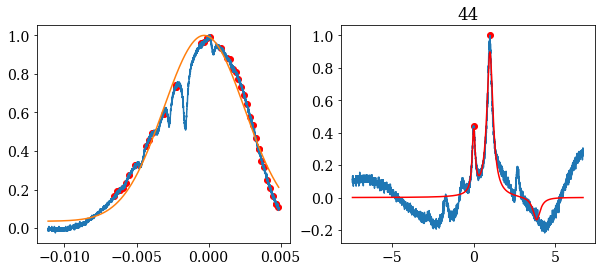

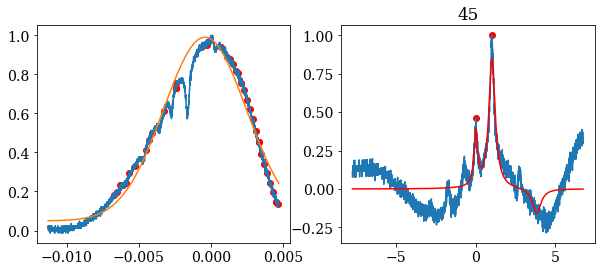

In [30]:
Gamma5 = []
for i in range(43, 46, 1):
    data = pd.read_csv("./data_saturation/scope_csv_{}.csv".format(i), skiprows=1)
    t, ch1, ch2 = data.iloc[::,0], data.iloc[::,1], data.iloc[::,2]
    t-= t[np.argmax(ch1)]
    ch1 -= ch1[100]
    ch1 /= np.max(ch1)
    t, ch1 = np.array(t), np.array(ch1)
    

#     ab = np.intersect1d(np.argwhere(t > -0.008), np.argwhere(t < 0.0035))
    x, y = t, ch1
    

    idx = [1150, 1200, 1250,1300,1350 ,1400, 1500, 1700, 1750, 1800, 
           2010, 2221,2222, 2223,2224, 2650, 2700, 2750,2800, 3000, 3100, 3150, 3200,3250, 3300,3350, 3400,3450, 3500, 3550, 3600, 3650, 3650, 3700, 3750, 3800, 3850,3900, 3950, 3960, 3990]
    
    
    plt.figure(figsize=(10,4))
    plt.subplot(121)
    plt.scatter(x[idx], y[idx], color="red")
    plt.plot(t, ch1)
    
    try:
        popt, pcov = curve_fit(mode, x[idx], y[idx], p0=[0.015, 0.01, 1.0, -0.2])
        plt.plot(t, mode(t, *popt))
    except RuntimeError:
        print(" o ")
        pass
    

    
    plt.subplot(122)
    ch1_new = -ch1 + mode(t, *popt)
    ch1_new /= np.max(ch1_new)
    t_new = 0.58/(popt[0]*np.sqrt(8*np.log(2)))*1000
    peaks, _ = find_peaks(ch1_new, height=0.3, distance=150)
    t_new = t - t[peaks[0]]
    t_new /= t_new[peaks[1]]
    
    plt.plot(t_new, ch1_new)
    c, d = -1, 4
    
    temp_idx = np.intersect1d(np.argwhere(t_new > c), np.argwhere(t_new < d))
    t_x, t_y = t_new[temp_idx], ch1_new[temp_idx]
#     plt.plot(t_new, ch1_new, color="orange")
    
    
    peaks, _ = find_peaks(t_y, distance=200, height=0.4)
    plt.scatter(t_x[peaks], t_y[peaks], color="red")
    plt.title(i)
#     print(t_new[peaks])
    popt, pcov = curve_fit(lorenz_sum, t_x, t_y, p0=[ 0.8,0.55,0.0,   0.8,1.0,1.55,    0.8, 0.2,2.8])
    plt.plot(t_new, lorenz_sum(t_new, *popt), color="red")

    
    g1, a1, m1, g2, a2, m2, g3, a3, m3 = popt
    

    Gamma5.append(g2)

In [31]:
t_new[peaks[1]]

-5.753623188405851

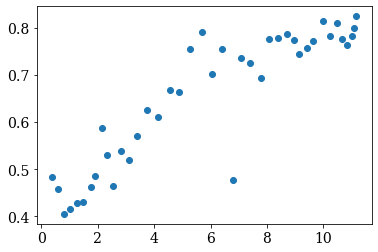

In [32]:
G = np.append(G, Gamma5)
plt.scatter(power[:len(G)], G)

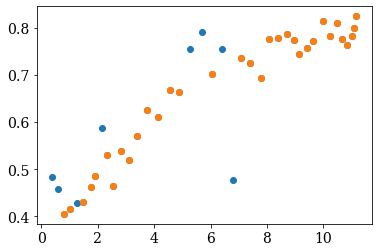

In [33]:
P, Gamma = np.array(power[:len(G)]), np.array(G)
# Gamma *= 0.58/

idx = np.argsort(P)
P, Gamma = P[idx], Gamma[idx]

plt.scatter(P, Gamma)
a = [0,1,4, 8, 18,19,22,21]

P = np.delete(P, a)
Gamma = np.delete(Gamma, a)


plt.scatter(P, Gamma)

[22.28976565  0.33510903]


/var/folders/h9/ll8t8frd1r575llt96l1glhm0000gn/T/ipykernel_3639/3107454862.py:2: RuntimeWarning: invalid value encountered in sqrt
  return g0 * np.sqrt(1 + k*x)


Text(0.5, 1.0, 'Ширина линии от мощности')

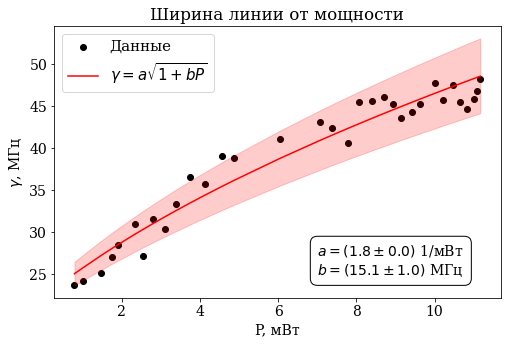

In [34]:
def sat_curve(x, g0, k):
    return g0 * np.sqrt(1 + k*x)


popt, pcov = curve_fit(sat_curve, P, Gamma*58.5)


plt.figure(figsize=(8, 5))
plt.scatter(P, Gamma*58.5, color="black", label="Данные")
plt.plot(P, sat_curve(P, *popt), color="red", 
         label="$\\gamma = a \\sqrt{1 + b P}$")
plt.xlabel("P, мВт")
plt.ylabel("$\gamma$, МГц")



print(popt)
sg, sk = (pcov[0][0])**0.5, (pcov[1][1])**0.5
plt.annotate(xy=(7, 25), 
             text="$a = ({}\pm{})$ 1/мВт \n".format(round(k,1), round(sk,1)) + "$b = ({}\pm{})$ МГц".format(round(g,1), round(sg,1)), 
            bbox=dict(boxstyle="round, pad=0.5", fc="w"))
g, k = popt
plt.fill_between(P, sat_curve(P, g-sg, k-sk), sat_curve(P, g+sg, k+sk), color="red", alpha=0.2)
plt.legend(fontsize=15)
plt.title("Ширина линии от мощности")

# plt.savefig("/Users/goloshch/Desktop/Материалы/КРФ ФИАН/SaturatedRb/images/saturation.pdf")

In [ ]:
m = 87 * 1.66e-27
k = 1.38e-23
T = 300
v = np.sqrt(8 * k * T / np.pi / m)
D = 3 * 1e-3

# Времяпролетное уширение
# Нужно уточнить скорость и размеры пучка
g = 3.25e-3 / v
g * 1e6

In [ ]:
plt.imshow(image)

In [ ]:
import matplotlib.image as img
image = img.imread("./images/beam3.jpg")

pixel_size = 9e-6**2

plt.figure(figsize=(5, 9))
new_image = image[540:780, 1130:1280]
plt.imshow(image[540:780, 1130:1280])
new_image = np.mean(new_image, axis=2)
print(new_image.shape)


print(150/2.5 * 9e-6 * 1e3)
print(240/2.5 * 9e-6 * 1e3)

lenx, leny = new_image.shape


cx, cy = np.arange(lenx), np.arange(leny)




# x0, y0 = np.where(new_image == 101)[:2]
# x1, y1 = np.where(new_image == 102)[:2]
# x2, y2 = np.where(new_image == 103)[:2]
# x3, y3 = np.where(new_image == 104)[:2]



# x12, y12 = np.append(x1, x2), np.append(y1, y2)
# x03, y03 = np.append(x0, x3), np.append(y0, y3)
# x, y = np.append(x12, x03), np.append(y12, y03)
# plt.scatter(y03, x03, color="red", s=5)

# cy, cx = np.mean(y3), np.mean(x3)-6
# plt.scatter(cy, cx, color="white")

# idx_min = np.argmin((x03-cx)**2 + (y03-cy)**2)
# idx_max = np.argmax((x03-cx)**2 + (y03-cy)**2)

# plt.scatter(y[idx_min], x[idx_min], color="blue")

# image = image[400:900, 1000:1400]

In [ ]:
cs = plt.contour(X, Y, Z, levels=[round(np.max(Z)/np.e**2)-1, round(np.max(Z)/np.e**2),round(np.max(Z)/np.e**2)+1])

X, Y = [], []

for item in cs.collections:
    for i in item.get_paths():
        v = i.vertices
        x = v[:, 0]
        y = v[:, 1]
        
        X.append(x)
        Y.append(y)

In [ ]:
plt.scatter(x, y)

In [ ]:
# 


from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse

points = np.array([X, Y]).T

a_points = np.array(points)
x = a_points[:, 0]
y = a_points[:, 1]

ell = EllipseModel()
ell.estimate(a_points)

xc, yc, a, b, theta = ell.params

print("center = ",  (xc, yc))
print("angle of rotation = ",  theta)
print("axes = ", (a,b))

fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)
axs[0].scatter(x,y)

axs[1].scatter(x, y)
axs[1].scatter(xc, yc, color='red', s=100)
axs[1].set_xlim(x.min(), x.max())
axs[1].set_ylim(y.min(), y.max())

ell_patch = Ellipse((xc, yc), 2*a, 2*b, theta*180/np.pi, edgecolor='red', facecolor='none')

axs[1].add_patch(ell_patch)
plt.show()

In [ ]:
pip install skimage

In [ ]:
X = np.arange(0, image.shape[1])
Y = np.arange(0, image.shape[0])
Z = image.mean(axis=2)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 500)


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('I')
ax.set_xticks([])
ax.set_yticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_zlim(0, 200)
ax.view_init(60, 30)
fig.savefig("visualize3d/{}.jpg".format(i))


In [ ]:
print(np.max(image))

In [ ]:
Z.mean(axis=2)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# setup the figure and axes
fig = plt.figure(figsize=(8, 3))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

# fake data

_xx, _yy = np.meshgrid(X, Y)
X, Y = _xx.ravel(), _yy.ravel()

top = image.mean(axis=2)
bottom = np.zeros_like(top)
width = depth = 1

ax1.bar3d(X, Y, bottom, width, depth, top, shade=True)
ax1.set_title('Shaded')

ax2.bar3d(X, Y, bottom, width, depth, top, shade=False)
ax2.set_title('Not Shaded')

plt.show()

In [ ]:
plt.figure(figsize=(8, 5))
for i in range(4, 46, 1):
    data = pd.read_csv("./data_saturation/scope_csv_{}.csv".format(i), skiprows=1)
    t, ch1, ch2 = data.iloc[::,0], data.iloc[::,1], data.iloc[::,2]
#     t-= t[np.argmax(ch1)]
#     ch1 -= ch1[100]
#     ch1 /= np.max(ch1)
#     t, ch1 = np.array(t), np.array(ch1)
    plt.plot(t, ch1, alpha=0.5)
    plt.xticks([])
    plt.yticks([])
    
    plt.annotate(xy=(0.897, 0.9), text="Спасибо за внимание!", fontsize=15)
    
plt.savefig("/Users/goloshch/Desktop/Материалы/КРФ ФИАН/SaturatedRb/images/final.pdf")